In [1]:
# Install required packages
!pip install tensorflow==2.10.0
!pip install matplotlib
!pip install numpy
!pip install pillow
!pip install scikit-learn
!pip install tqdm

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split


ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.10.0


In [2]:
# Download and extract the Oxford-IIIT Pet Dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz

# Set paths
IMAGE_DIR = "images/"
MASK_DIR = "annotations/trimaps/"

# Get all image and mask file names from their respective directories
all_image_names = {f.split('.')[0] for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')}
all_mask_names = {f.split('.')[0] for f in os.listdir(MASK_DIR) if f.endswith('.png') and not f.startswith('._')}

# Find common base names (images for which a mask also exists)
common_names = list(all_image_names.intersection(all_mask_names))
common_names.sort()

# Reconstruct image and mask file lists using only common names
image_files_filtered = [f + '.jpg' for f in common_names]
mask_files_filtered = [f + '.png' for f in common_names]

# Limit the dataset for faster training in Colab
# Remove this line or increase the number to use more data
# We'll limit to a smaller number to ensure faster execution in Colab
limit_size = min(1000, len(image_files_filtered))
image_files = image_files_filtered[:limit_size]
mask_files = mask_files_filtered[:limit_size]

# Split the dataset
train_images, test_images, train_masks, test_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

In [3]:
# Define image and mask dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Function to preprocess images
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0  # Normalize to [0,1]
    return img

# Function to preprocess masks
def preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # The mask contains values 1, 2, 3. We'll convert to 0, 1, 2
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    mask = tf.one_hot(tf.squeeze(mask), depth=3)
    return mask

# Create dataset
def create_dataset(image_files, mask_files, batch_size=16):
    image_paths = [os.path.join(IMAGE_DIR, img) for img in image_files]
    mask_paths = [os.path.join(MASK_DIR, mask) for mask in mask_files]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Map the preprocessing functions
    dataset = dataset.map(
        lambda x, y: (preprocess_image(x), preprocess_mask(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Create training and validation datasets
BATCH_SIZE = 16
train_dataset = create_dataset(train_images, train_masks, BATCH_SIZE)
test_dataset = create_dataset(test_images, test_masks, BATCH_SIZE)

In [4]:
# Define the UNET model
def build_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=3):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder (Contracting Path)
    # Level 1
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Level 2
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Level 3
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Level 4 (Bottleneck)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)

    # Decoder (Expansive Path)
    # Level 3
    up3 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(drop4)
    concat3 = tf.keras.layers.Concatenate()([conv3, up3])
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(concat3)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    # Level 2
    up2 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    concat2 = tf.keras.layers.Concatenate()([conv2, up2])
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat2)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    # Level 1
    up1 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    concat1 = tf.keras.layers.Concatenate()([conv1, up1])
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat1)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Build the model
model = build_unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ dropout[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 512)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]  

 Total params: 7,697,475 (29.36 MB)

 Trainable params: 7,697,475 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Define metrics for segmentation
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.keras.backend.sum(y_true,[1,2,3]) + tf.keras.backend.sum(y_pred,[1,2,3]) - intersection
    iou = tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[dice_coefficient, iou_coefficient, 'accuracy']
)

# Define callbacks
checkpoint_path = "/content/drive/MyDrive/unet_pet_segmentation.h5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        verbose=1,
        mode='min'
    )
]

# Train the model
EPOCHS = 25
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5121 - dice_coefficient: 0.3698 - iou_coefficient: 0.2281 - loss: 1.0369
Epoch 1: val_loss improved from inf to 0.93673, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 430ms/step - accuracy: 0.5127 - dice_coefficient: 0.3704 - iou_coefficient: 0.2286 - loss: 1.0360 - val_accuracy: 0.5663 - val_dice_coefficient: 0.4337 - val_iou_coefficient: 0.2787 - val_loss: 0.9367 - learning_rate: 1.0000e-04
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5821 - dice_coefficient: 0.4495 - iou_coefficient: 0.2926 - loss: 0.9171
Epoch 2: val_loss improved from 0.93673 to 0.79526, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.5825 - dice_coefficient: 0.4500 - iou_coefficient: 0.2930 - loss: 0.9166 - val_accuracy: 0.6679 - val_dice_coefficient: 0.5175 - val_iou_coefficient: 0.3505 - val_loss: 0.7953 - learning_rate: 1.0000e-04
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6714 - dice_coefficient: 0.5343 - iou_coefficient: 0.3675 - loss: 0.7943
Epoch 3: val_loss improved from 0.79526 to 0.73767, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.6715 - dice_coefficient: 0.5345 - iou_coefficient: 0.3677 - loss: 0.7942 - val_accuracy: 0.7088 - val_dice_coefficient: 0.5533 - val_iou_coefficient: 0.3848 - val_loss: 0.7377 - learning_rate: 1.0000e-04
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6995 - dice_coefficient: 0.5677 - iou_coefficient: 0.3998 - loss: 0.7432
Epoch 4: val_loss improved from 0.73767 to 0.71128, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.6995 - dice_coefficient: 0.5678 - iou_coefficient: 0.3999 - loss: 0.7433 - val_accuracy: 0.7070 - val_dice_coefficient: 0.5837 - val_iou_coefficient: 0.4147 - val_loss: 0.7113 - learning_rate: 1.0000e-04
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7119 - dice_coefficient: 0.5904 - iou_coefficient: 0.4235 - loss: 0.7019
Epoch 5: val_loss improved from 0.71128 to 0.69174, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.7119 - dice_coefficient: 0.5905 - iou_coefficient: 0.4236 - loss: 0.7019 - val_accuracy: 0.7219 - val_dice_coefficient: 0.5776 - val_iou_coefficient: 0.4092 - val_loss: 0.6917 - learning_rate: 1.0000e-04
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7291 - dice_coefficient: 0.6088 - iou_coefficient: 0.4433 - loss: 0.6672
Epoch 6: val_loss improved from 0.69174 to 0.64739, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.7291 - dice_coefficient: 0.6090 - iou_coefficient: 0.4436 - loss: 0.6670 - val_accuracy: 0.7357 - val_dice_coefficient: 0.6128 - val_iou_coefficient: 0.4456 - val_loss: 0.6474 - learning_rate: 1.0000e-04
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7453 - dice_coefficient: 0.6347 - iou_coefficient: 0.4715 - loss: 0.6267
Epoch 7: val_loss improved from 0.64739 to 0.62653, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.7454 - dice_coefficient: 0.6349 - iou_coefficient: 0.4717 - loss: 0.6266 - val_accuracy: 0.7448 - val_dice_coefficient: 0.6333 - val_iou_coefficient: 0.4676 - val_loss: 0.6265 - learning_rate: 1.0000e-04
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7600 - dice_coefficient: 0.6558 - iou_coefficient: 0.4948 - loss: 0.5918
Epoch 8: val_loss improved from 0.62653 to 0.58693, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.7600 - dice_coefficient: 0.6559 - iou_coefficient: 0.4949 - loss: 0.5917 - val_accuracy: 0.7620 - val_dice_coefficient: 0.6544 - val_iou_coefficient: 0.4912 - val_loss: 0.5869 - learning_rate: 1.0000e-04
Epoch 9/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7758 - dice_coefficient: 0.6803 - iou_coefficient: 0.5232 - loss: 0.5556
Epoch 9: val_loss improved from 0.58693 to 0.57206, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.7758 - dice_coefficient: 0.6804 - iou_coefficient: 0.5232 - loss: 0.5555 - val_accuracy: 0.7682 - val_dice_coefficient: 0.6621 - val_iou_coefficient: 0.5000 - val_loss: 0.5721 - learning_rate: 1.0000e-04
Epoch 10/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7850 - dice_coefficient: 0.6931 - iou_coefficient: 0.5384 - loss: 0.5351
Epoch 10: val_loss improved from 0.57206 to 0.55244, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.7850 - dice_coefficient: 0.6931 - iou_coefficient: 0.5385 - loss: 0.5350 - val_accuracy: 0.7758 - val_dice_coefficient: 0.6761 - val_iou_coefficient: 0.5164 - val_loss: 0.5524 - learning_rate: 1.0000e-04
Epoch 11/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7938 - dice_coefficient: 0.7064 - iou_coefficient: 0.5545 - loss: 0.5133
Epoch 11: val_loss improved from 0.55244 to 0.54684, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.7939 - dice_coefficient: 0.7065 - iou_coefficient: 0.5546 - loss: 0.5133 - val_accuracy: 0.7787 - val_dice_coefficient: 0.6789 - val_iou_coefficient: 0.5200 - val_loss: 0.5468 - learning_rate: 1.0000e-04
Epoch 12/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8002 - dice_coefficient: 0.7145 - iou_coefficient: 0.5645 - loss: 0.4979
Epoch 12: val_loss improved from 0.54684 to 0.53492, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.8003 - dice_coefficient: 0.7146 - iou_coefficient: 0.5646 - loss: 0.4978 - val_accuracy: 0.7843 - val_dice_coefficient: 0.6942 - val_iou_coefficient: 0.5380 - val_loss: 0.5349 - learning_rate: 1.0000e-04
Epoch 13/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8101 - dice_coefficient: 0.7268 - iou_coefficient: 0.5795 - loss: 0.4761
Epoch 13: val_loss improved from 0.53492 to 0.49496, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.8101 - dice_coefficient: 0.7269 - iou_coefficient: 0.5796 - loss: 0.4760 - val_accuracy: 0.8024 - val_dice_coefficient: 0.7215 - val_iou_coefficient: 0.5710 - val_loss: 0.4950 - learning_rate: 1.0000e-04
Epoch 14/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8233 - dice_coefficient: 0.7472 - iou_coefficient: 0.6046 - loss: 0.4448
Epoch 14: val_loss improved from 0.49496 to 0.47805, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.8233 - dice_coefficient: 0.7472 - iou_coefficient: 0.6047 - loss: 0.4448 - val_accuracy: 0.8096 - val_dice_coefficient: 0.7194 - val_iou_coefficient: 0.5686 - val_loss: 0.4780 - learning_rate: 1.0000e-04
Epoch 15/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8292 - dice_coefficient: 0.7532 - iou_coefficient: 0.6122 - loss: 0.4308
Epoch 15: val_loss improved from 0.47805 to 0.45951, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.8292 - dice_coefficient: 0.7533 - iou_coefficient: 0.6122 - loss: 0.4308 - val_accuracy: 0.8199 - val_dice_coefficient: 0.7342 - val_iou_coefficient: 0.5869 - val_loss: 0.4595 - learning_rate: 1.0000e-04
Epoch 16/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8355 - dice_coefficient: 0.7635 - iou_coefficient: 0.6253 - loss: 0.4175
Epoch 16: val_loss did not improve from 0.45951
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.8354 - dice_coefficient: 0.7634 - iou_coefficient: 0.6252 - loss: 0.4176 - val_accuracy: 0.8207 - val_dice_coefficient: 0.7105 - val_iou_coefficient: 0.5571 - val_loss: 0.4707 - learning_rate: 1.0000e-04
Epoch 17/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8370 - dice_coefficient: 0.7610 - iou_coefficient: 0.6224 - loss: 0.4196
Epoch 17: val_loss did not improve from 0.45951
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.8370 - dice_coefficient: 0.7610 - iou_coefficien

50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.8403 - dice_coefficient: 0.7648 - iou_coefficient: 0.6275 - loss: 0.4084 - val_accuracy: 0.8186 - val_dice_coefficient: 0.7402 - val_iou_coefficient: 0.5956 - val_loss: 0.4574 - learning_rate: 1.0000e-04
Epoch 19/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8472 - dice_coefficient: 0.7766 - iou_coefficient: 0.6423 - loss: 0.3883
Epoch 19: val_loss improved from 0.45735 to 0.43386, saving model to /content/drive/MyDrive/unet_pet_segmentation.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.8472 - dice_coefficient: 0.7767 - iou_coefficient: 0.6424 - loss: 0.3883 - val_accuracy: 0.8297 - val_dice_coefficient: 0.7603 - val_iou_coefficient: 0.6212 - val_loss: 0.4339 - learning_rate: 1.0000e-04
Epoch 20/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8592 - dice_coefficient: 0.7926 - iou_coefficient: 0.6632 - loss: 0.3624
Epoch 20: val_loss did not improve from 0.43386
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.8591 - dice_coefficient: 0.7926 - iou_coefficient: 0.6632 - loss: 0.3625 - val_accuracy: 0.8302 - val_dice_coefficient: 0.7669 - val_iou_coefficient: 0.6302 - val_loss: 0.4343 - learning_rate: 1.0000e-04
Epoch 21/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8673 - dice_coefficient: 0.8023 - iou_coefficient: 0.6761 - loss: 0.3457
Epoch 21: val_loss did not improve from 0.43386
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.8672 - dice_coefficient: 0.8022 - iou_coefficien

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.8726 - dice_coefficient: 0.8139 - iou_coefficient: 0.6924 - loss: 0.3291 - val_accuracy: 0.8412 - val_dice_coefficient: 0.7887 - val_iou_coefficient: 0.6592 - val_loss: 0.4205 - learning_rate: 1.0000e-04
Epoch 24/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8837 - dice_coefficient: 0.8286 - iou_coefficient: 0.7127 - loss: 0.3016
Epoch 24: val_loss did not improve from 0.42051
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.8837 - dice_coefficient: 0.8286 - iou_coefficient: 0.7126 - loss: 0.3018 - val_accuracy: 0.8354 - val_dice_coefficient: 0.7904 - val_iou_coefficient: 0.6620 - val_loss: 0.4381 - learning_rate: 1.0000e-04
Epoch 25/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8867 - dice_coefficient: 0.8346 - iou_coefficient: 0.7213 - loss: 0.2935
Epoch 25: val_loss did not improve from 0.42051
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.8867 - dice_coefficient: 0.8346 - iou_coefficien

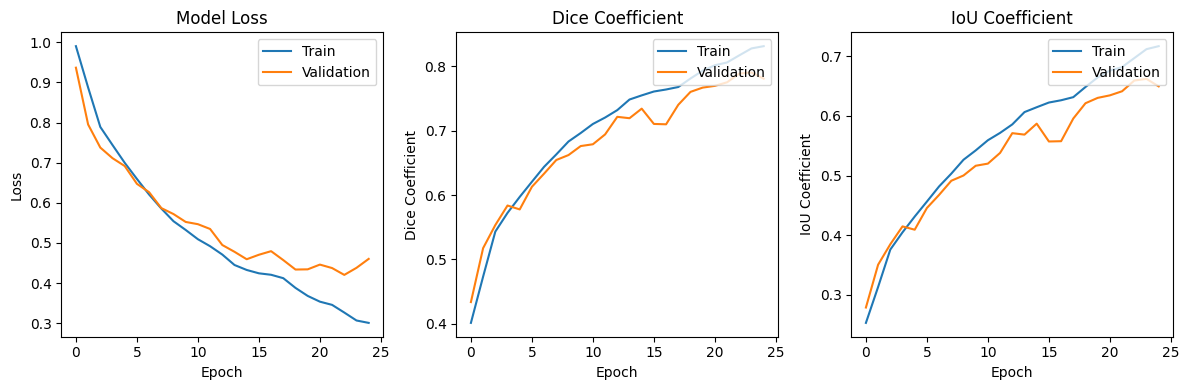

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.8252 - dice_coefficient: 0.7768 - iou_coefficient: 0.6441 - loss: 0.4705
Test Loss: 0.4604
Test Dice Coefficient: 0.7808
Test IoU Coefficient: 0.6495
Test Accuracy: 0.8281


In [6]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation dice coefficient values
    plt.subplot(1, 3, 2)
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation IoU values
    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou_coefficient'])
    plt.plot(history.history['val_iou_coefficient'])
    plt.title('IoU Coefficient')
    plt.ylabel('IoU Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate the model on the test set
test_loss, test_dice, test_iou, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test IoU Coefficient: {test_iou:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step


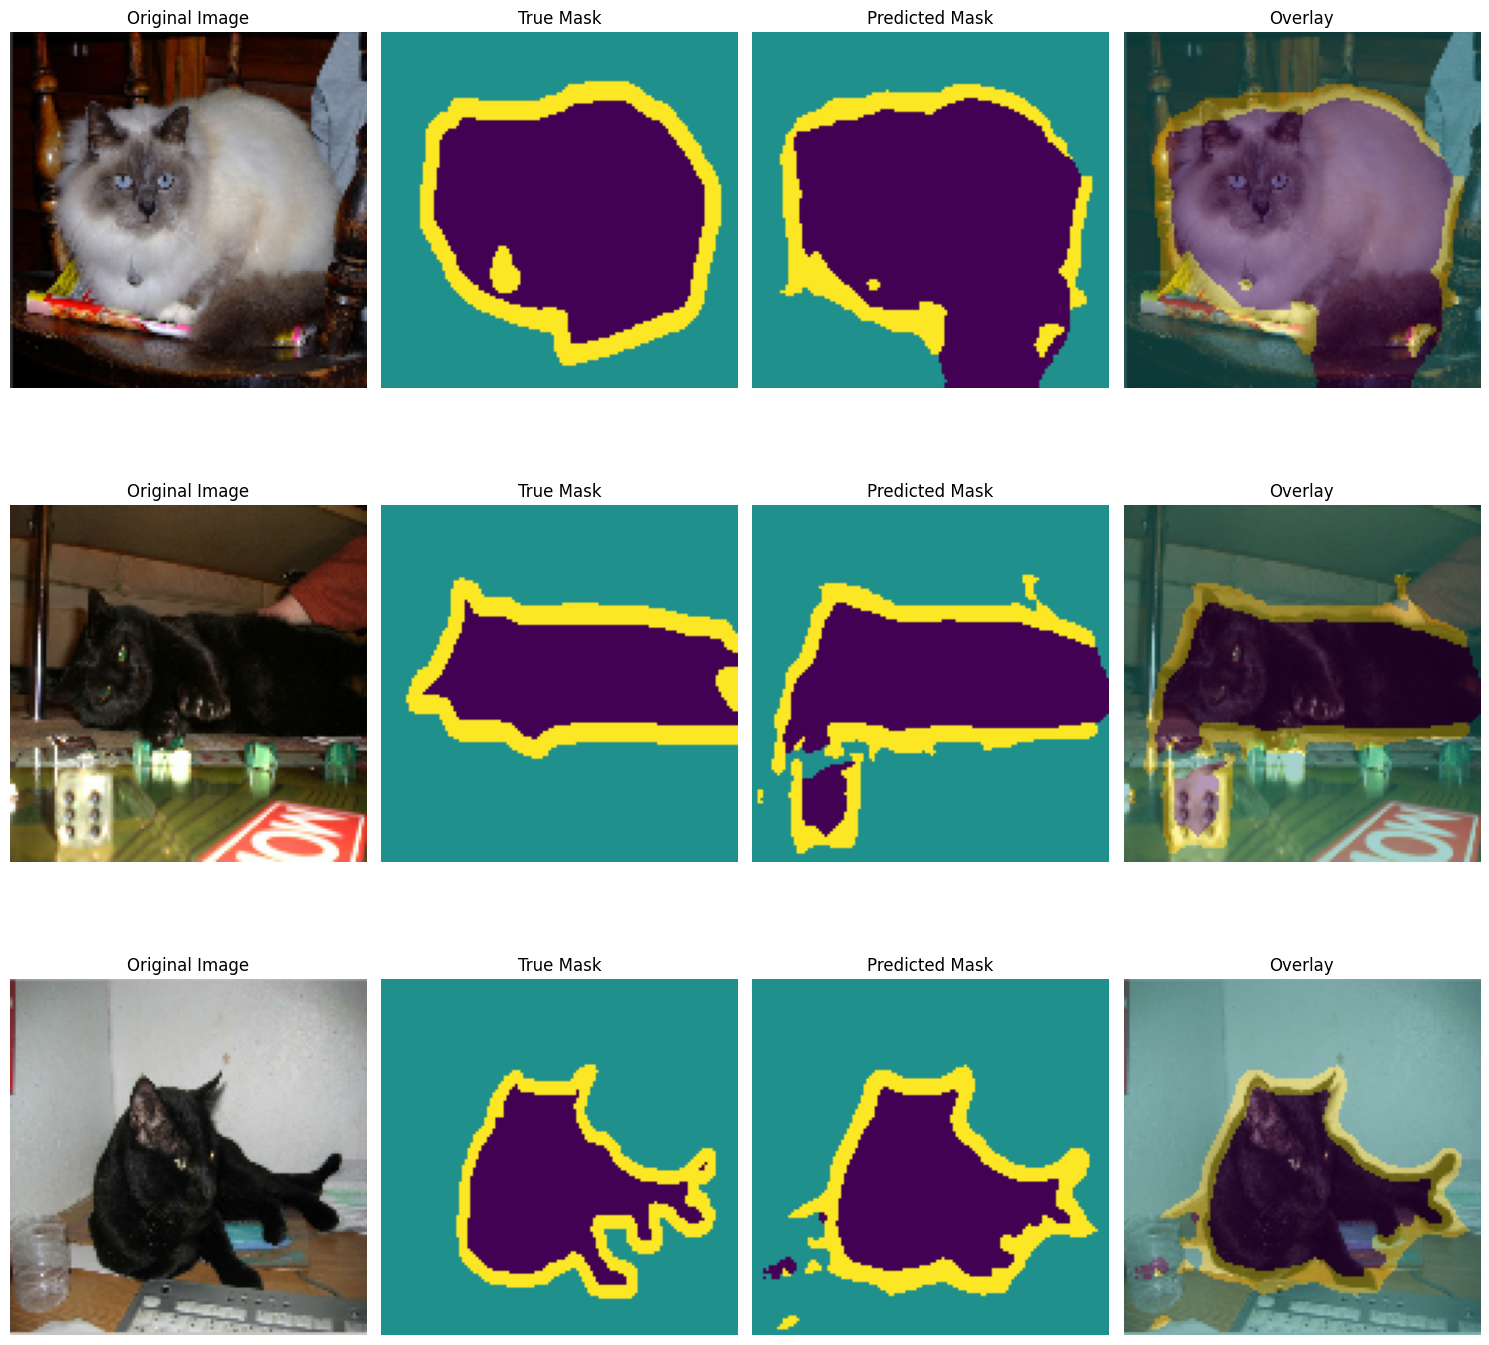

In [7]:
# Function to visualize predictions
def visualize_predictions(model, dataset, num_samples=3):
    # Get a batch of test data
    images, masks = next(iter(dataset))

    # Make predictions
    predictions = model.predict(images)

    # Convert predictions to class indices
    pred_masks = np.argmax(predictions, axis=-1)
    true_masks = np.argmax(masks.numpy(), axis=-1)

    # Visualize
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(min(num_samples, len(images))):
        # Original image
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        # True mask
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(true_masks[i], cmap='viridis')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(pred_masks[i], cmap='viridis')
        plt.title('Predicted Mask')
        plt.axis('off')

        # Overlay
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(images[i])
        plt.imshow(pred_masks[i], cmap='viridis', alpha=0.4)
        plt.title('Overlay')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset)